In [257]:
import os
import re
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

# %matplotlib inline
warnings.filterwarnings('ignore')

In [258]:
sys.path.append(os.path.join('..', 'src'))

In [259]:
import importlib
import utils, params
importlib.reload(utils)
from utils import capture_data

importlib.reload(params)
from params import ProjectParameters

# Define paths

In [260]:
inputs = os.path.join('..', 'data', '03_processed')
outputs = os.path.join('..', 'data', '03_processed')
reports = os.path.join('..', 'data', '06_reporting')

# Data capture
As dataset is small, we might export data to a pandas dataframe.

In [261]:
data               = capture_data(inputs, 'X_train.csv')
data_test          = capture_data(inputs, 'X_test.csv')
y_train            = capture_data(inputs, 'y_train.csv')
y_test             = capture_data(inputs, 'y_test.csv')

In [262]:
data = data.merge(y_train, left_index=True, right_index=True)
data_test = data_test.merge(y_test, left_index=True, right_index=True)
data = data.append(data_test)
for c in ['preset_1', 'preset_2']:
    data[c] = data[c].astype('int64')

# Histograms on Normal and Failed cycles

In [263]:
cols = ['preset_1', 'preset_2', 'temperature', 'pressure', 'vibrationx', 'vibrationy', 'vibrationz', 'y']
data = data[cols]

## All cycles

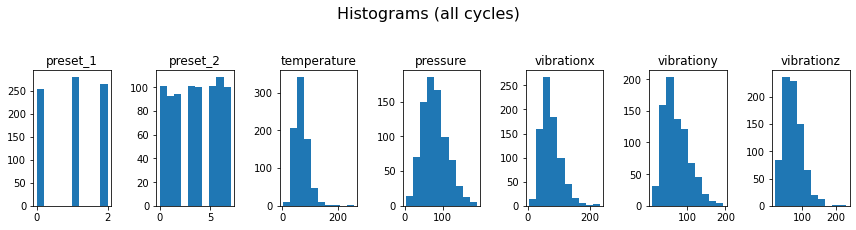

In [287]:
fig, axes = plt.subplots(1,len(cols),figsize=(12,3))

for i, (ax, col) in enumerate(zip(axes, cols)):
    if col == 'y': continue
    ax.hist(data.iloc[:,i])
    ax.set_title(col)

plt.suptitle('Histograms (all cycles)', y=1.05, size=16)
plt.tight_layout();
file = 'cluster_hist1.jpg'
plt.savefig(os.path.join(reports, file), bbox_inches = "tight")

## Only failed cycles

In [265]:
data_positives = data[data.y == 1]

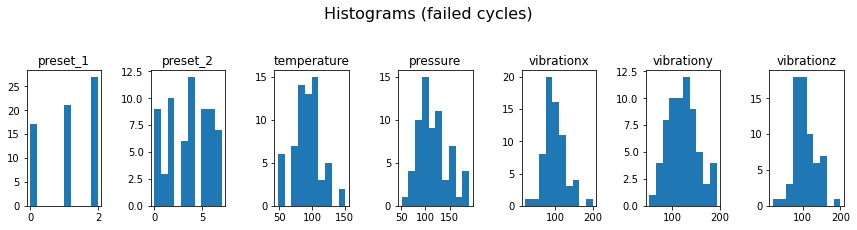

In [286]:
fig, axes = plt.subplots(1,len(cols),figsize=(12,3))

for i, (ax, col) in enumerate(zip(axes, cols)):
    ax.hist(data_positives.iloc[:,i])
    ax.set_title(col)

plt.suptitle('Histograms (failed cycles)', y=1.05, size=16)
plt.tight_layout();
file = 'cluster_hist2.jpg'
plt.savefig(os.path.join(reports, file), bbox_inches = "tight")

We can see that:
* Preset_1 has more failures on setup 1 and less failures on setup 3.
* Preset_2 has some setups with lower failure, such as setups 3 and 4. It has setups with higher failure such as setups 1 and 5.
* It seems that higher pressure leads to higher frequency of failures.
* For the parameter variables (vibration, temperature, pressure), it also seems that higher levels lead to higher failure.

# Clustering

In [267]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [268]:
X = data.drop(['y'], axis=1)

In [269]:
mask = data.y == 1

### Standardize the data

In [270]:
X_std = StandardScaler().fit_transform(X)

## by PCA (Principal Component Analysis)

In [271]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

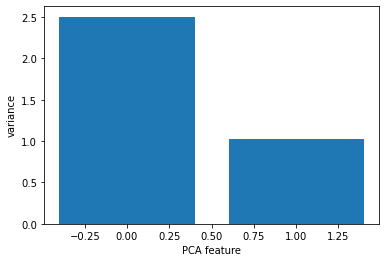

In [272]:
# PCA variance
scaler = StandardScaler()
pca = PCA(n_components = 2)
pipeline = make_pipeline(scaler,pca)
pipeline.fit(X)

plt.bar(range(pca.n_components_), pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.show()

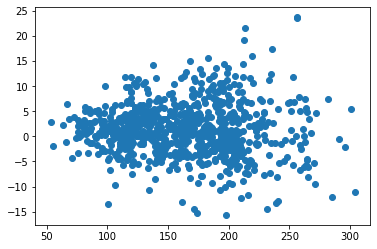

In [273]:
# pca = PCA(n_components = 2)
# pca.fit(data.iloc[:, :-1])
X_pca = pca.transform(X)
x = X_pca[:,0]
y = X_pca[:,1]
plt.scatter(x,y)
plt.show()

### Kmeans using PCA

First, let's try to define an optimal number of centroids for kmeans. This can be done by using Elbow method based on the sum of squared distance (SSE) between data points and their clusters' centroids. By this heuristic method, we pick the spot where SSE starts to flatten out or forms an elbow. As we can see, data doesn't flatten out, but it forms an elbow when number of clusters equals 2. Also, as data is small, I would not recommended to use more than 2 centroids, which can be ilustrated graphically (some steps below).

In [274]:
masked_data = X_std[mask]

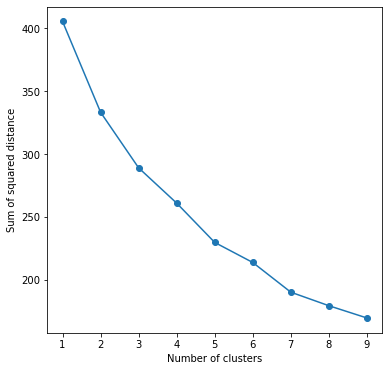

In [275]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(masked_data)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters')
plt.ylabel('Sum of squared distance');

KMeans is done with n_init=10, which means 10 iterations are done, then the one with lowest inertia is chosen.

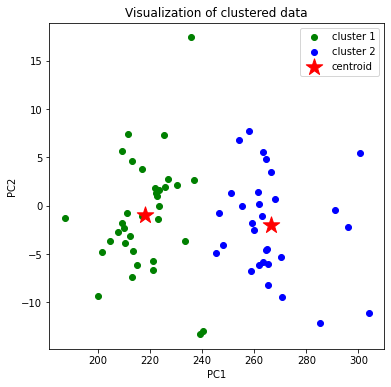

In [291]:
masked_data = X_pca[mask]

# Run local implementation of kmeans
km = KMeans(n_clusters=2, max_iter=100)
km.fit(masked_data)
centroids = km.cluster_centers_

# Plot the clustered data
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(masked_data[km.labels_ == 0, 0], masked_data[km.labels_ == 0, 1],
            c='green', label='cluster 1')
plt.scatter(masked_data[km.labels_ == 1, 0], masked_data[km.labels_ == 1, 1],
            c='blue', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
            c='r', label='centroid')
plt.legend()
# plt.xlim([-2, 2])
# plt.ylim([-2, 2])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualization of clustered data')

file = 'cluster_pca.jpg'
plt.savefig(os.path.join(reports, file), bbox_inches = "tight")

# Kmeans on variables (without PCA)
* https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html

In [277]:
cols.remove('y')

In [278]:
masked_data = X_std[mask]
X_std = pd.DataFrame(X_std, columns = cols)
masked_data = pd.DataFrame(masked_data, columns = cols)

### plot kmeans in 3D (3 variable choices)

In [279]:
from mpl_toolkits.mplot3d import Axes3D

In [290]:
def plot_kmeans(vars_list, file):
    vars_dict = {}
    vars_dict[0] = masked_data.loc[:, vars_list[0]]
    vars_dict[1] = masked_data.loc[:, vars_list[1]]
    vars_dict[2] = masked_data.loc[:, vars_list[2]]

    estimators = [('k_means_iris_2', KMeans(n_clusters=2)),
                  ('k_means_iris_3', KMeans(n_clusters=3))]

    fignum = 1
    titles = ['2 clusters', '3 clusters']
    for name, est in estimators:
        fig = plt.figure(fignum, figsize=(4, 3))
        ax = Axes3D(fig, rect=[0, 0, .95, 3], elev=30, azim=134)
        est.fit(masked_data)
        labels = est.labels_

        colors = labels.astype(np.float)
        colors = ['red' if i==0 else i for i in colors]
        colors = ['green' if i==1 else i for i in colors]
        colors = ['blue' if i==2 else i for i in colors]

        ax.scatter(vars_dict[0], vars_dict[1], vars_dict[2],
                   c=colors, edgecolor='k')

        ax.w_xaxis.set_ticklabels([])
        ax.w_yaxis.set_ticklabels([])
        ax.w_zaxis.set_ticklabels([])
        ax.set_xlabel(vars_list[0])
        ax.set_ylabel(vars_list[1])
        ax.set_zlabel(vars_list[2])
        ax.set_title(titles[fignum - 1])
        ax.dist = 12
        fignum = fignum + 1

    fig.show()
    plt.tight_layout();
    plt.savefig(os.path.join(reports, file), bbox_inches = "tight")
#     plt.savefig(os.path.join(reports, file))

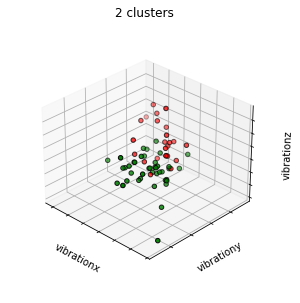

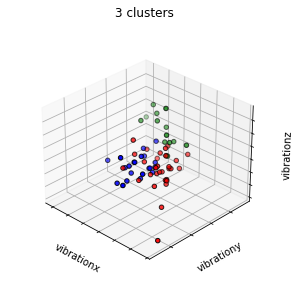

In [289]:
variables = ['vibrationx', 'vibrationy', 'vibrationz']
plot_kmeans(variables, 'cluster_3d_1')

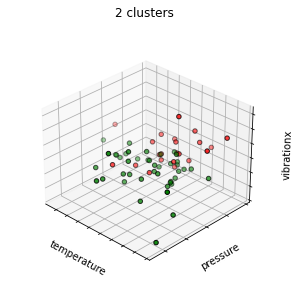

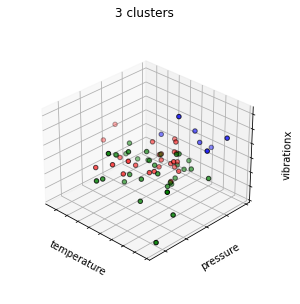

In [283]:
variables = ['temperature', 'pressure', 'vibrationx']
plot_kmeans(variables, 'cluster_3d_2')

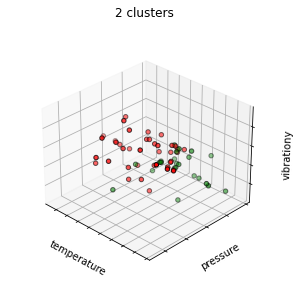

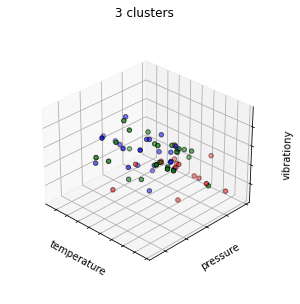

In [284]:
variables = ['temperature', 'pressure', 'vibrationy']
plot_kmeans(variables, 'cluster_3d_3')

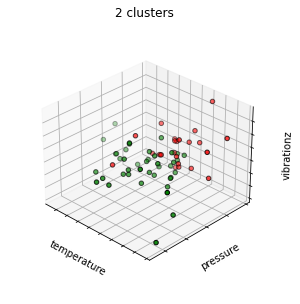

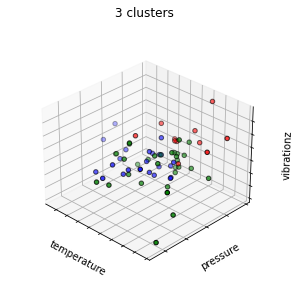

In [285]:
variables = ['temperature', 'pressure', 'vibrationz']
plot_kmeans(variables, 'cluster_3d_4')

# manual clustering

In [295]:
def get_comp(preset1, preset2):
    preset = str(preset1)+'_'+str(preset2)
#     preset = int(preset)
    return preset
data['preset_comp'] = data.apply(lambda x: get_comp(x['preset_1'], x['preset_2']), axis=1)

In [308]:
import statistics

for preset in ['preset_1', 'preset_2', 'preset_comp']:
    unique_presets = data[preset].unique()
    proportions = {}
    for val in unique_presets:
        df = data[data[preset] == val]
        total = df.shape[0]
        positives = df[df['y'] == 1].shape[0]
        proportions[val] = round(positives / total,2)
    #     proportions[val] = positives

    values = [v for v in proportions.values()]
    prop_mean = statistics.mean(values)
    prop_std = statistics.stdev(values)
    n = len(values)

    group1 = []
    group2 = []
    group3 = []
    for k,v in proportions.items():
        if v < prop_mean: 
            group1.append(k)
        elif v >= prop_mean and v <= prop_mean + 1.96*prop_std: 
            group2.append(k)
        else: group3.append(k)
    print()
    print(group1)
    print(group2)
    print(group3)


[0, 1]
[2]
[]

[1, 3, 6, 7]
[0, 2, 4, 5]
[]

['1_1', '1_3', '1_4', '2_3', '2_7', '0_7', '0_2', '1_0', '1_5', '0_1', '0_3', '0_5', '1_6']
['0_0', '1_2', '2_5', '2_1', '0_6', '2_2', '2_0', '0_4', '2_6', '1_7']
['2_4']


In [309]:
sum_v = 0
for v in proportions.values():
    sum_v += v
sum_v

2.0000000000000004

In [310]:
proportions

{'0_0': 0.1,
 '1_1': 0.03,
 '1_2': 0.13,
 '1_3': 0.08,
 '1_4': 0.07,
 '2_5': 0.13,
 '2_3': 0.05,
 '2_1': 0.09,
 '0_6': 0.09,
 '2_7': 0.08,
 '2_2': 0.12,
 '0_7': 0.03,
 '2_0': 0.09,
 '0_4': 0.14,
 '0_2': 0.07,
 '1_0': 0.08,
 '1_5': 0.06,
 '2_6': 0.11,
 '1_7': 0.11,
 '0_1': 0.0,
 '2_4': 0.16,
 '0_3': 0.06,
 '0_5': 0.07,
 '1_6': 0.05}

# Final thoughts
We could not find relevant clusters with the variable selections with kmeans above.

Using kmeans with PCA shows that there might exist between 2 and 3 clusters, but further analysis is necessary.

Also, by analysing the histograms, we can see that:
* Preset_1 has more failures on setup 2 and less failures on setup 0.
* Preset_2 has some setups with lower failure, such as setups 1 and 3. It has setups with higher failure such as setups 2 and 4.
* It seems that higher levels on parameters leads to higher frequency of failures.

For better conclusions, we could run regression models to evaluate how each variable individually affects Failure.

I could have separated parameters according to risk of failure